In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the combined dataset
df = dd.read_csv("combined_file.csv", parse_dates=True, infer_datetime_format=True)

C:\Users\sandh\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:640: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  head = reader(BytesIO(b_sample), nrows=sample_rows, **head_kwargs)


In [3]:
# Convert Dask DataFrame to Pandas DataFrame for analysis
df_sample = df.sample(frac=0.1).compute()  # Sampling 10% to avoid memory issues

C:\Users\sandh\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = reader(bio, **kwargs)
C:\Users\sandh\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
C:\Users\sandh\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
C:\Users\sandh\anaconda3\Lib\site-packages\dask\dataframe\io\csv.py:195: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see ht

In [5]:
# Identify datetime columns correctly (excluding non-date object columns)
possible_datetime_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime"]  # Known datetime columns

for col in possible_datetime_cols:
    try:
        df_sample[col] = pd.to_datetime(df_sample[col])
        print(f"Converted {col} to datetime.")
    except Exception as e:
        print(f"Could not convert {col} to datetime: {e}")

Converted tpep_pickup_datetime to datetime.
Converted tpep_dropoff_datetime to datetime.


In [6]:
# Feature Engineering
df_sample["trip_duration"] = (df_sample["tpep_dropoff_datetime"] - df_sample["tpep_pickup_datetime"]).dt.total_seconds() / 60
df_sample["hour_of_day"] = df_sample["tpep_pickup_datetime"].dt.hour
df_sample["day_of_week"] = df_sample["tpep_pickup_datetime"].dt.day_name()
df_sample["is_weekend"] = df_sample["day_of_week"].isin(["Saturday", "Sunday"]).astype(int)

In [7]:
# Outlier Detection using IQR Method
numerical_cols = df_sample.select_dtypes(include=["int64", "float64"]).columns
outliers = {}

for col in numerical_cols:
    Q1 = df_sample[col].quantile(0.25)
    Q3 = df_sample[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = df_sample[(df_sample[col] < lower_bound) | (df_sample[col] > upper_bound)]

In [8]:
# Display outlier statistics
for col, outlier_df in outliers.items():
    print(f"\n{col} - Outliers detected: {len(outlier_df)}")


Unnamed: 0 - Outliers detected: 0

VendorID - Outliers detected: 335612

passenger_count - Outliers detected: 280210

trip_distance - Outliers detected: 173265

RatecodeID - Outliers detected: 75851

PULocationID - Outliers detected: 0

DOLocationID - Outliers detected: 0

payment_type - Outliers detected: 359335

fare_amount - Outliers detected: 138679

extra - Outliers detected: 23716

mta_tax - Outliers detected: 31152

tip_amount - Outliers detected: 78928

tolls_amount - Outliers detected: 102333

improvement_surcharge - Outliers detected: 21601

total_amount - Outliers detected: 164001

congestion_surcharge - Outliers detected: 109057

Airport_fee - Outliers detected: 106031

trip_duration - Outliers detected: 82449


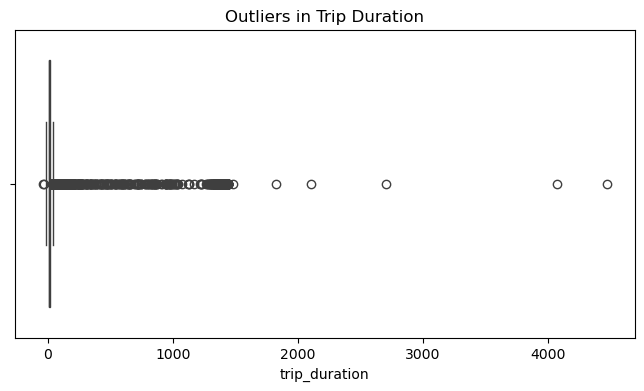

In [9]:
# Plot outliers for trip duration
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_sample["trip_duration"])
plt.title("Outliers in Trip Duration")
plt.show()

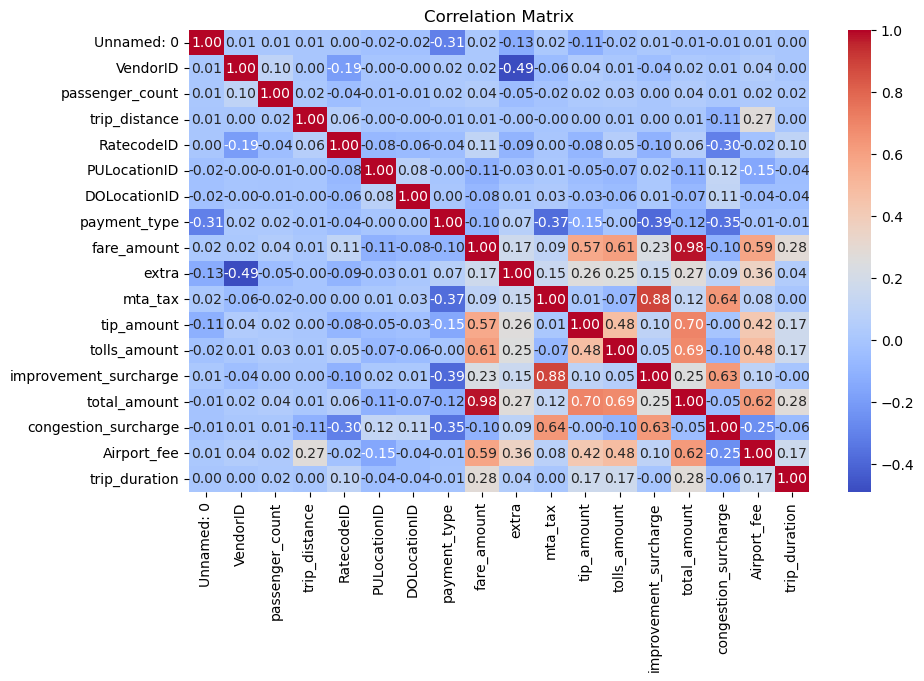

In [10]:
# Correlation Matrix (Only Numerical Columns)
plt.figure(figsize=(10, 6))
sns.heatmap(df_sample[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [11]:
# Display the cleaned dataset overview
print("\nCleaned Dataset Overview:")
print(df_sample.info())


Cleaned Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 1382830 entries, 297457 to 429268
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1382830 non-null  int64         
 1   VendorID               1382830 non-null  int64         
 2   tpep_pickup_datetime   1382830 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  1382830 non-null  datetime64[ns]
 4   passenger_count        1240379 non-null  float64       
 5   trip_distance          1382830 non-null  float64       
 6   RatecodeID             1240379 non-null  float64       
 7   store_and_fwd_flag     1240379 non-null  object        
 8   PULocationID           1382830 non-null  int64         
 9   DOLocationID           1382830 non-null  int64         
 10  payment_type           1382830 non-null  int64         
 11  fare_amount            1382830 non-null  float64       
 12  ex

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [13]:
# Machine Learning: Predicting Trip Duration using Random Forest
# Selecting relevant features
features = ["PULocationID", "DOLocationID", "passenger_count", "trip_distance", "hour_of_day", "is_weekend"]
target = "trip_duration"

In [14]:
# Drop rows with missing values in selected columns
df_sample = df_sample.dropna(subset=features + [target])

In [15]:
# Splitting dataset
X = df_sample[features]
y = df_sample[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [17]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [18]:
# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
print(f"R² Score: {r2:.2f}")


Model Performance:
Mean Absolute Error (MAE): 5.58 minutes
R² Score: -0.07


In [19]:
# Display the cleaned dataset overview
print("\nCleaned Dataset Overview:")
print(df_sample.info())


Cleaned Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 1240379 entries, 297457 to 170474
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1240379 non-null  int64         
 1   VendorID               1240379 non-null  int64         
 2   tpep_pickup_datetime   1240379 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  1240379 non-null  datetime64[ns]
 4   passenger_count        1240379 non-null  float64       
 5   trip_distance          1240379 non-null  float64       
 6   RatecodeID             1240379 non-null  float64       
 7   store_and_fwd_flag     1240379 non-null  object        
 8   PULocationID           1240379 non-null  int64         
 9   DOLocationID           1240379 non-null  int64         
 10  payment_type           1240379 non-null  int64         
 11  fare_amount            1240379 non-null  float64       
 12  ex

In [20]:
# Optimize integer columns
int_cols = ["VendorID", "PULocationID", "DOLocationID", "payment_type"]
df_sample[int_cols] = df_sample[int_cols].astype("int32")

In [21]:
# Optimize float columns
float_cols = [
    "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount",
    "improvement_surcharge", "total_amount", "congestion_surcharge",
    "Airport_fee", "trip_duration", "trip_distance"
]
df_sample[float_cols] = df_sample[float_cols].astype("float32")

In [22]:
# Convert categorical columns to "category" dtype
cat_cols = ["store_and_fwd_flag", "day_of_week"]
df_sample[cat_cols] = df_sample[cat_cols].astype("category")

print("\nOptimized Dataset Info:")
print(df_sample.info(memory_usage="deep"))


Optimized Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1240379 entries, 297457 to 170474
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1240379 non-null  int64         
 1   VendorID               1240379 non-null  int32         
 2   tpep_pickup_datetime   1240379 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  1240379 non-null  datetime64[ns]
 4   passenger_count        1240379 non-null  float64       
 5   trip_distance          1240379 non-null  float32       
 6   RatecodeID             1240379 non-null  float64       
 7   store_and_fwd_flag     1240379 non-null  category      
 8   PULocationID           1240379 non-null  int32         
 9   DOLocationID           1240379 non-null  int32         
 10  payment_type           1240379 non-null  int32         
 11  fare_amount            1240379 non-null  float32       
 12  extr

In [23]:
# Advance Feature Engineering
df_sample["speed_mph"] = (df_sample["trip_distance"] / (df_sample["trip_duration"] / 60)).replace([np.inf, -np.inf], np.nan)
df_sample["month"] = df_sample["tpep_pickup_datetime"].dt.month
df_sample["is_peak_hour"] = df_sample["hour_of_day"].between(7, 9) | df_sample["hour_of_day"].between(17, 19)

In [24]:
from scipy.stats import zscore

# Detect outliers using Z-score
z_scores = np.abs(zscore(df_sample[["trip_distance", "trip_duration", "fare_amount"]]))
df_sample["outlier"] = (z_scores > 3).any(axis=1)

# Remove outliers
df_clean = df_sample[~df_sample["outlier"]]
print(f"Rows before: {len(df_sample)}, After Removing Outliers: {len(df_clean)}")

Rows before: 1240379, After Removing Outliers: 1222692
